In [77]:
import numpy as np
import sys
#!{sys.executable} -m pip install do_mpc
import do_mpc
# !{sys.executable} -mpip install slycot  
# !{sys.executable} -mpip install control
import control
# import slycot
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from math import inf, pi, sin, cos
# !{sys.executable} -m pip install --upgrade scipy
import scipy
from scipy.integrate import odeint, solve_ivp
import matplotlib.animation as animation

# Semestralni prace

## Parameters  of system (inverse pendulum)

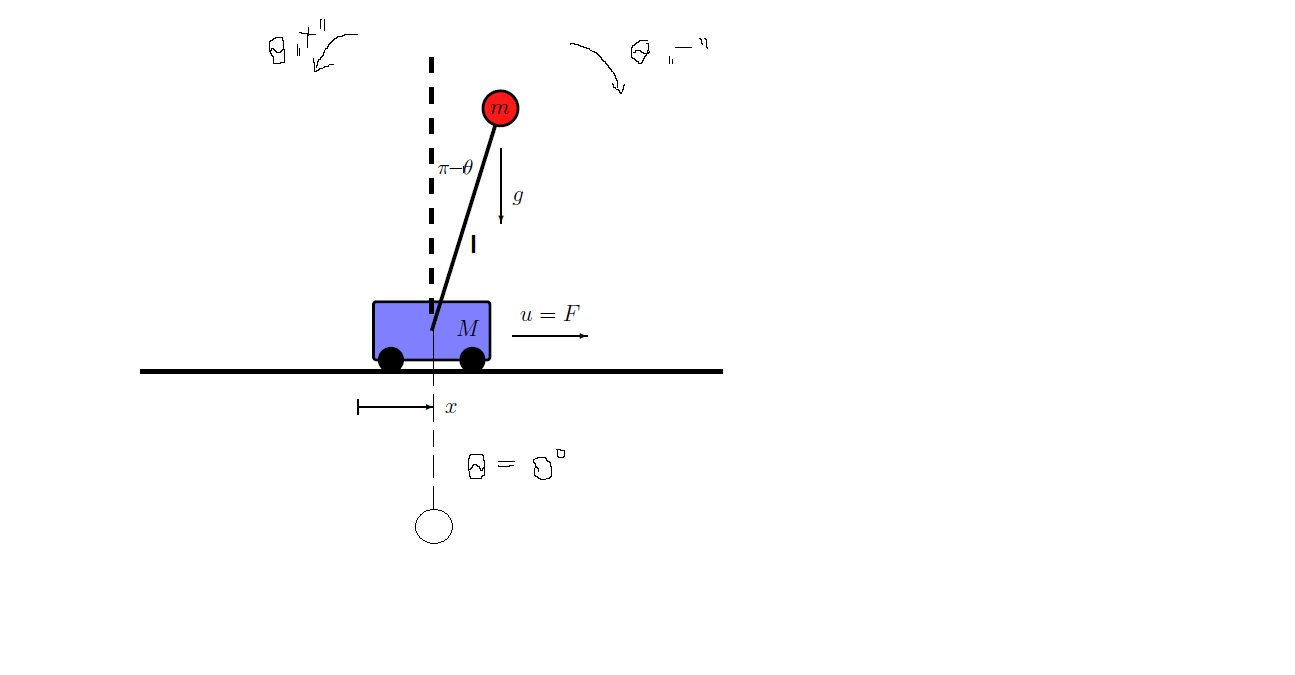

In [2]:
m = 1      # mass of pendulum 
M = 5      # mass of cart 
L = 2      # length of pend 
g = -9.81    
d = 1      # coeefficient of friction
b = 1      # cos(theta) for theta = pi

### Equations:

$
x = 
\begin{bmatrix}
       x \cr
       \dot{x} \cr
       \theta \cr
       \dot{\theta}
\end{bmatrix}$ 
$= 
\begin{bmatrix}
       x_1 \cr
       x_2 \cr
       x_3 \cr
       x_4
\end{bmatrix}$ 


$\ddot{x} = \frac{-m^2.l^2.g.cos(\theta).sin(\theta) + m.l^2(m.l.\dot{\theta}^2.sin(\theta) -b.\dot{x}) +m.l^2.F}{m.l^2(M+m(1-cos^2(\theta)))}$

$\ddot{\theta} = \frac{(m+M)m.g.l.sin(\theta)-m.l.cos(\theta)(m.l.\dot{\theta}^2.sin(\theta)-b.\dot{x})-m.l.cos(\theta).F}{m.l^2(M+m(1-cos^2(\theta)))}$

$\dot{x}_1 = x_2$

$\dot{x}_2 = \frac{-m^2.l^2.g.cos(x_3).sin(x_3) + m.l^2(m.l.x_4^2.sin(x_3) -b.x_2 +m.l^2.F}{m.l^2(M+m(1-cos^2(x_3)))}$

$\dot{x}_3 = x_4$

$\dot{x}_4 = \frac{(m+M)m.g.l.sin(x_3)-m.l.cos(x_3)(m.l.x_4^2.sin(x_3)-b.x_2)-m.l.cos(x_3).F}{m.l^2(M+m(1-cos^2(x_3)))}$


### Linearization:

In [3]:
# Linearizace kolem bodu theta = pi

A = [[0, 1, 0, 0],
    [0, -d/M, b*m*g/M, 0],
    [0, 0, 0, 1],
    [0, -b*d/(M*L), -b*(m+M)*g/(M*L), 0]]
B = [[0], [1/M], [0], [b*1/(M*L)]]
C = [[1, 0, 0, 0],[0, 0, 1, 0]]
D = [[0], [0]]
inv_pend_linsys = control.StateSpace(A, B, C, D)

print(A)
print(B)
print(C)
print(D)

[[0, 1, 0, 0], [0, -0.2, -1.9620000000000002, 0], [0, 0, 0, 1], [0, -0.1, 5.886, 0]]
[[0], [0.2], [0], [0.1]]
[[1, 0, 0, 0], [0, 0, 1, 0]]
[[0], [0]]


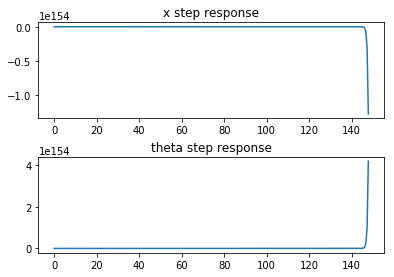

In [4]:
response = control.step_response(inv_pend_linsys)

fig, axs = plt.subplots(2)
axs[0].plot(response.time, response.outputs[0][0])
axs[0].set_title('x step response')
axs[1].plot(response.time, response.outputs[1][0])
axs[1].set_title('theta step response')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

# Soustava je nestabilni

In [5]:
w, v = np.linalg.eig(A)

In [6]:
print(w) # eigenvalues (vlastni cisla), jedno je kladne -> system je nestabilni

[ 0.         -2.40772302 -0.23364538  2.4413684 ]


#### Controllability and observability

In [7]:
# Making controllability gram matrix:

R = control.ctrb(A, B) # [B, A*B, A^2*B, A^3*B]
O = control.obsv(A, C)
print(R)
print(np.linalg.matrix_rank(R))
print(O)
print(np.linalg.matrix_rank(O))

[[ 0.       0.2     -0.04    -0.1882 ]
 [ 0.2     -0.04    -0.1882   0.07688]
 [ 0.       0.1     -0.02     0.5926 ]
 [ 0.1     -0.02     0.5926  -0.0989 ]]
4
[[ 1.      0.      0.      0.    ]
 [ 0.      0.      1.      0.    ]
 [ 0.      1.      0.      0.    ]
 [ 0.      0.      0.      1.    ]
 [ 0.     -0.2    -1.962   0.    ]
 [ 0.     -0.1     5.886   0.    ]
 [ 0.      0.04    0.3924 -1.962 ]
 [ 0.      0.02    0.1962  5.886 ]]
4


## State feedback controller:

In [8]:
# Place new poles, so the system would be stable: 

des_eig = [-1.1, -1.2, -1.3, -1.4]
K = control.place(A, B, des_eig)

print(K)

[[ -1.74923547  -6.64292995 155.85847095  61.28585991]]


In [9]:
# New eigenvalues of the close loop system with state controller, so the system is now stable:

w_n, v_n = np.linalg.eig(A-B*K)
print(w_n)

[-1.4 -1.3 -1.1 -1.2]


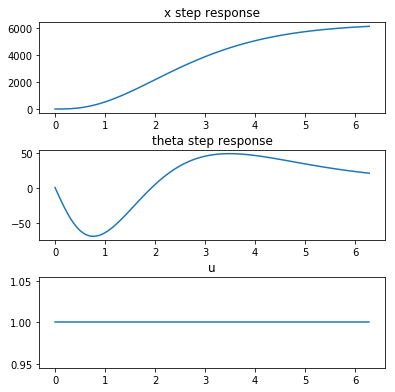

In [10]:
# trying out step on system with state controller: 

state_ctrl_fdbk_sys = control.StateSpace(A-B*K, -K.transpose(), C, D)

response_state_ctrl = control.step_response(state_ctrl_fdbk_sys)

fig, axs = plt.subplots(3)
axs[0].plot(response_state_ctrl.time, response_state_ctrl.outputs[0][0])
axs[0].set_title('x step response')
axs[1].plot(response_state_ctrl.time, response_state_ctrl.outputs[1][0])
axs[1].set_title('theta step response')
axs[2].plot(response_state_ctrl.time, response_state_ctrl.inputs[0][0])
axs[2].set_title('u')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

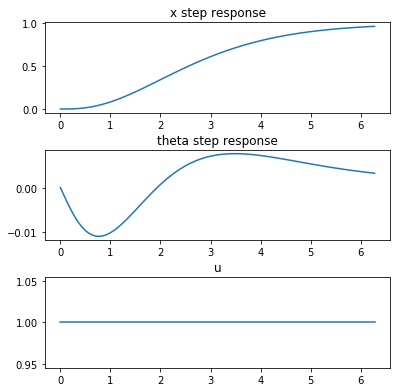

In [11]:
# rescaling:

k_ctrl_fdbk = control.dcgain(state_ctrl_fdbk_sys)
kr = [1/k_ctrl_fdbk[0][0], 1, 1/k_ctrl_fdbk[1][0], 1]

state_ctrl_fdbk_sys = control.StateSpace(A-B*K, -K.transpose(), C, D)

state_ctrl_fdbk_sys *= kr

response_state_ctrl = control.step_response(state_ctrl_fdbk_sys)

fig, axs = plt.subplots(3)
axs[0].plot(response_state_ctrl.time, response_state_ctrl.outputs[0][0])
axs[0].set_title('x step response')
axs[1].plot(response_state_ctrl.time, response_state_ctrl.outputs[1][0])
axs[1].set_title('theta step response')
axs[2].plot(response_state_ctrl.time, response_state_ctrl.inputs[0][0])
axs[2].set_title('u')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

## LQR controller design with control lib. python:

In [80]:
Q = [[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 10, 0],[0, 0, 0, 1]]             # state cost matrix
R = [[0.01]]                                                              # input cost matrix

global K_lqr
K_lqr, S, E = control.lqr(A, B, Q, R)

print(K_lqr)

[[-10.         -22.74681353 314.26014127 123.42611623]]


[-2.58913063+0.54605j -2.58913063-0.54605j -1.547259  +0.j
 -1.26772866+0.j     ]


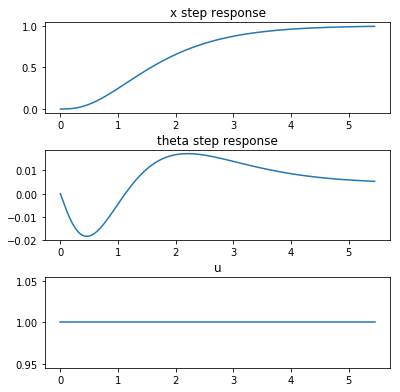

In [75]:
sys_lqr = control.StateSpace(A-B*K_lqr, -K_lqr.transpose(), C, D)

w,_ = np.linalg.eig(A-B*K_lqr)
print(w)

k_lqr = control.dcgain(sys_lqr)
kr = [1/k_lqr[0][0], 1, 1/k_lqr[1][0], 1]

sys_lqr *= kr                              # rescailing

response_lqr = control.step_response(sys_lqr)

fig, axs = plt.subplots(3)
axs[0].plot(response_lqr.time, response_lqr.outputs[0][0])
axs[0].set_title('x step response')
axs[1].plot(response_lqr.time, response_lqr.outputs[1][0])
axs[1].set_title('theta step response')
axs[2].plot(response_lqr.time, response_lqr.inputs[0][0])
axs[2].set_title('u')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

## Simulating nonlinear model of inverted pendulum with initial conditions (scipy.integrate.odeint):

In [81]:
t = np.arange(0, 20, 1e-3)


def F(x, t):
    
    return 0

def f(x, t):
    
    M = 5     # mass of the cart
    m = 1     # mass of the pendulum
    b = 1     # coefficient of the friction rotation
    g = -9.81    # acceleration of gravity
    l = 2     # length of shoulder of pendulum 
    
    d_x = np.zeros((4,))

    # Steve Burton's Model:
    Sx = sin(x[2])
    Cx = cos(x[2])
    denom = m*(l**2)*(M+m*(1-Cx**2))
    # dot_x
    d_x[0] = x[1]
    # ddot_x
    d_x[1] = (-(m**2)*(l**2)*g*Cx*Sx + m*(l**2)*(m*l*(x[3]**2)*Sx) - b*x[1] + m*(l**2)*F(x,t))/denom
    # dot_theta
    d_x[2] = x[3]
    # ddot_theta
    d_x[3] = ((m+M)*m*g*l*Sx - m*l*Cx*(m*l*(x[3]**2)*Sx-b*x[1]) - m*l*Cx*F(x,t))/denom

    return d_x




s = odeint(f, y0=[0, 0, -pi/8, 0], t=t)

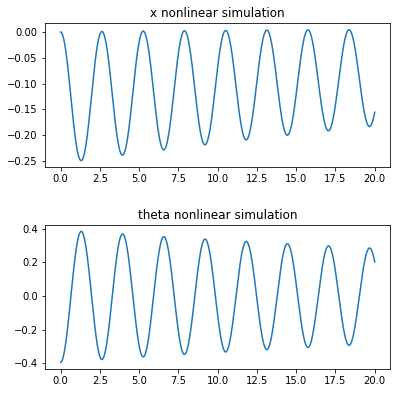

In [82]:
fig, axs = plt.subplots(2)
axs[0].plot(t, s[:, 0])
axs[0].set_title('x nonlinear simulation')
axs[1].plot(t, s[:, 2])
axs[1].set_title('theta nonlinear simulation')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

## Controlled non-linear model of inverted pendulum with inputs (scipy.integrate.odeint)

#### LQR

In [128]:
global dt
dt = 1e-2

# Set point
global SP
SP = np.asarray([[3.5], [0], [pi], [0]])        # set point 

x0 = np.asarray([-1, 0, pi-0.5, 0])     # initial conditions

t_end = 10 # [s]
t = np.arange(0, t_end, dt)
    
def F(x):
    
    e = x - SP.transpose()
    e = np.asarray(e[0])
    
    return (-K_lqr@e)[0]

def f(t, x):
    
    M = 5     # mass of the cart
    m = 1     # mass of the pendulum
    b = 1     # coefficient of the friction rotation
    g = -9.81    # acceleration of gravity
    l = 2     # length of shoulder of pendulum 
    
    d_x = np.zeros((4,))

    # Steve Burton's Model:
    Sx = sin(x[2])
    Cx = cos(x[2])
    denom = m*(l**2)*(M+m*(1-Cx**2))
    # dot_x
    d_x[0] = x[1]
    # ddot_x
    d_x[1] = (-(m**2)*(l**2)*g*Cx*Sx + m*(l**2)*(m*l*(x[3]**2)*Sx) - b*x[1] + m*(l**2)*F(x))/denom
    # dot_theta
    d_x[2] = x[3]
    # ddot_theta
    d_x[3] = ((m+M)*m*g*l*Sx - m*l*Cx*(m*l*(x[3]**2)*Sx-b*x[1]) - m*l*Cx*F(x))/denom
    
    return d_x



# s = odeint(f, y0=x0, t=t)
s = solve_ivp(f, [0, t_end], x0, method='RK45', max_step=dt, min_step=dt)

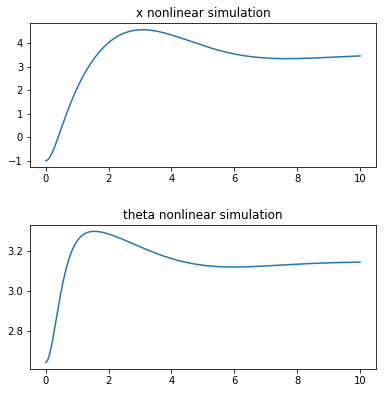

In [127]:
fig, axs = plt.subplots(2)
axs[0].plot(s.t, s.y[0])
axs[0].set_title('x nonlinear simulation')
axs[1].plot(s.t, s.y[2])
axs[1].set_title('theta nonlinear simulation')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)